# Stocks RNN Predictor

By: Kesavar Kabilar, Ryan James Laporte, and Carmelo Restivo-Caponcello

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
np.random.seed(7)

In [4]:
data_path = "/content/gdrive/My Drive/Project/Stocks/" # Change file directory

In [5]:
def get_all_files(data_path=data_path):
    """
    Given a path to the stocks data, this function will return the file 
    locations of companies consisting of at least 100 lines of previous stocks 
    data.
    """
    all_files = []

    for file in os.listdir(data_path)[:100]:
        f = open(data_path+file)
        if len(f.readlines()) > 100: 
            all_files.append(data_path+file)
        f.close()
    
    return all_files

all_files = get_all_files()

In [6]:
n = len(all_files)

all_files = np.array(all_files, dtype=str)
np.random.shuffle(all_files)

training_files = all_files[:int(n*0.6)] 
validation_files = all_files[int(n*0.6):int(n*0.8)]
test_files = all_files[int(n*0.8):]

In [7]:
def transform_data(file, K, augment=False):
    """
    Given a file, a K value it will return X, T. Each row of X contains K x 4 
    values where each row represents the open value, highest price, lowest 
    price, and the closing price. Each column represent the previous K days. 
    Each row of T represents the closing price of K+1 day. If augment is true, 
    the function will also add the reverse of the days.
    """
    X, T = [], []

    f = open(file, "r")

    all_data = []

    data = []
    for line in f.readlines()[-100:]:
        line = line.split(",")[1:-2]
        all_data.append(line)

        data.append(line)
        if len(data) == K+1:
            x = np.array(data[:-1], dtype=float)
            X.append(x)
            T.append(float(data[-1][-1]))

            data = data[1:]

    f.close()
    if augment:
        data = []
        for line in all_data[::-1]:

            data.append(line)
            if len(data) == K+1:
                x = np.array(data[:-1], dtype=float)
                X.append(x)
                T.append(float(data[-1][-1]))

                data = data[1:]
    
    return torch.tensor(np.array(X), dtype=torch.float), torch.tensor(np.array(T), dtype=torch.float)

In [8]:
class StocksRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StocksRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # normalize input
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s2*s3)
        min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
        x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
        x = x.reshape(s1, s2, s3)
        # RNN Layer
        out, _ = self.rnn(x)
        # Fully connected layer
        out = self.fc(out[:, -1, :])
        # Denormalize output
        return ((out.reshape(-1) * (max-min)) + min).reshape(-1, 1)

class StocksLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StocksLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # normalize input
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s2*s3)
        min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
        x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
        x = x.reshape(s1, s2, s3)
        # LSTM Layer
        out, _ = self.lstm(x)
        # Fully connected layer
        out = self.fc(out[:, -1, :])
        # Denormalize output
        return ((out.reshape(-1) * (max-min)) + min).reshape(-1, 1)


In [9]:
def get_mean_squared_error(model, files, K, incrDecr=False):
    """
    Given the model, a set of files, and K value, The function will calculate 
    the mean squared error of the dataset.
    """
    error = 0
    total = 0

    for f in files:
        x, t = transform_data(f, K)
        
        if incrDecr:
            output = model(x).reshape(-1)

            t[np.where(x[:, -1, -1] >= t)] = 0
            t[np.where(x[:, -1, -1] < t)] = 1
            output[np.where(x[:, -1, -1] >= output)] = 0
            output[np.where(x[:, -1, -1] < output)] = 1

        else:
            s1, s2, s3 = x.shape
            x = x.reshape(s1, s2*s3)
            min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
            x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
            x = x.reshape(s1, s2, s3)
            t = (t-min) / (max - min)

            output = model(x).reshape(-1)

        error += int(sum((output - t)**2).detach())
        total += output.shape[0]

    return error / total

In [10]:
def train_rnn_network(model, train, valid, num_epochs, batch_size, learning_rate, K, name, augment=False, show_data=True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    iter_x = []
    iter_t = []
    for f in train:
        x, t = transform_data(f, K, augment)
        iter_x.append(x)
        iter_t.append(t)

    train_data_x = torch.concat(iter_x, 0)
    train_data_t = torch.concat(iter_t, 0)

    for epoch in range(num_epochs):

        p = np.random.permutation(train_data_t.shape[0])
        X, T = train_data_x[p], train_data_t[p]

        for i in range(0, int(T.shape[0]), batch_size):
            batch_x = X[i: (i+batch_size)]
            batch_t = T[i: (i+batch_size)]
            pred = model(batch_x)
            loss = criterion(pred, batch_t.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_mean_squared_error(model, train, K))
        valid_acc.append(get_mean_squared_error(model, valid, K))
        if (epoch+1) % 10 == 0 and show_data:
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))

    if show_data:
        plt.title(name + " Training Curve")
        plt.plot(epochs, train_acc, label="Train")
        plt.plot(epochs, valid_acc, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Squared Error")
        plt.legend(loc='best')
        plt.savefig(name.replace(" ", "")+".png")
        plt.show()

Epoch 10; Loss 3.520073; Train Acc 0.312418; Val Acc 0.348366
Epoch 20; Loss 3.819596; Train Acc 0.195861; Val Acc 0.214379
Epoch 30; Loss 2.370922; Train Acc 0.137037; Val Acc 0.137908
Epoch 40; Loss 1.191177; Train Acc 0.133987; Val Acc 0.129412
Epoch 50; Loss 1.432157; Train Acc 0.128540; Val Acc 0.124183
Epoch 60; Loss 0.881820; Train Acc 0.123747; Val Acc 0.118954
Epoch 70; Loss 0.759832; Train Acc 0.118519; Val Acc 0.114379
Epoch 80; Loss 0.677019; Train Acc 0.113725; Val Acc 0.109150
Epoch 90; Loss 1.623192; Train Acc 0.108715; Val Acc 0.103922
Epoch 100; Loss 0.181747; Train Acc 0.104139; Val Acc 0.099346
Epoch 110; Loss 0.998752; Train Acc 0.100654; Val Acc 0.098039
Epoch 120; Loss 0.313323; Train Acc 0.096514; Val Acc 0.094118
Epoch 130; Loss 1.513895; Train Acc 0.094771; Val Acc 0.091503
Epoch 140; Loss 0.242337; Train Acc 0.093464; Val Acc 0.088889
Epoch 150; Loss 0.583882; Train Acc 0.091503; Val Acc 0.087582
Epoch 160; Loss 0.991142; Train Acc 0.089760; Val Acc 0.086928
E

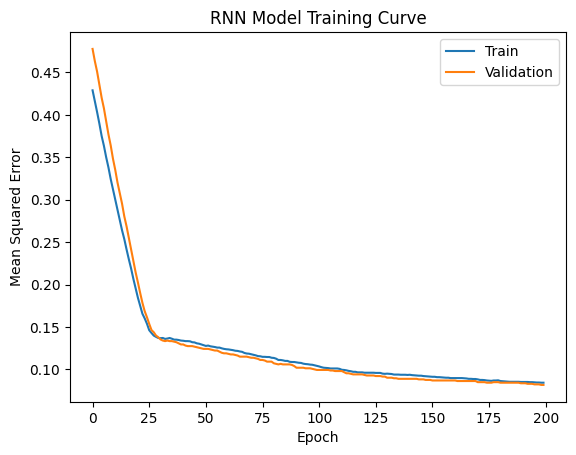

Test Data Error:  0.07925696594427245
Test Data Increase/Decrease Accuracy:  0.48111455108359136


In [19]:
modelRNN = StocksRNN(4, 150)
train_rnn_network(modelRNN, 
                  training_files, 
                  validation_files, 
                  num_epochs=200, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=15, 
                  name="RNN Model")
print("Test Data Error: ", get_mean_squared_error(modelRNN, test_files, 15))
print("Test Data Increase/Decrease Accuracy: ", get_mean_squared_error(modelRNN, test_files, 15, incrDecr=True))

Epoch 10; Loss 5.690441; Train Acc 0.337908; Val Acc 0.375163
Epoch 20; Loss 3.235267; Train Acc 0.297821; Val Acc 0.331373
Epoch 30; Loss 3.330622; Train Acc 0.256645; Val Acc 0.284967
Epoch 40; Loss 2.609362; Train Acc 0.212200; Val Acc 0.233333
Epoch 50; Loss 1.318862; Train Acc 0.163834; Val Acc 0.177124
Epoch 60; Loss 1.193697; Train Acc 0.126144; Val Acc 0.130719
Epoch 70; Loss 1.073863; Train Acc 0.120697; Val Acc 0.116340
Epoch 80; Loss 2.963436; Train Acc 0.120697; Val Acc 0.115686
Epoch 90; Loss 0.865647; Train Acc 0.119172; Val Acc 0.113072
Epoch 100; Loss 0.482703; Train Acc 0.118083; Val Acc 0.112418
Epoch 110; Loss 0.655643; Train Acc 0.115686; Val Acc 0.110458
Epoch 120; Loss 0.898989; Train Acc 0.114379; Val Acc 0.108497
Epoch 130; Loss 0.619996; Train Acc 0.112200; Val Acc 0.107843
Epoch 140; Loss 1.188087; Train Acc 0.110675; Val Acc 0.106536
Epoch 150; Loss 0.806682; Train Acc 0.108932; Val Acc 0.105229
Epoch 160; Loss 0.748664; Train Acc 0.107190; Val Acc 0.102614
E

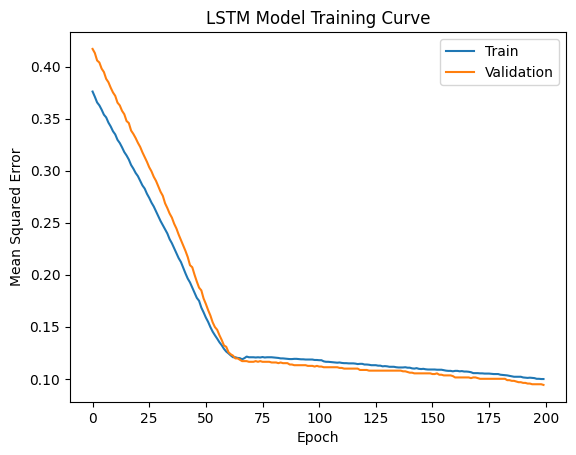

Test Data Accuracy:  0.09164086687306501
Test Data Increase/Decrease Accuracy:  0.4934984520123839


In [15]:
modelLSTM = StocksLSTM(4, 150)
train_rnn_network(modelLSTM, 
                  training_files, 
                  validation_files, 
                  num_epochs=200, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=15, 
                  name="LSTM Model")
print("Test Data Accuracy: ", get_mean_squared_error(modelLSTM, test_files, 15))
print("Test Data Increase/Decrease Accuracy: ", get_mean_squared_error(modelLSTM, test_files, 15, incrDecr=True))

Epoch 10; Loss 1.838664; Train Acc 0.238344; Val Acc 0.262745
Epoch 20; Loss 0.440894; Train Acc 0.107625; Val Acc 0.109150
Epoch 30; Loss 0.710955; Train Acc 0.096950; Val Acc 0.095425
Epoch 40; Loss 1.009166; Train Acc 0.090632; Val Acc 0.087582
Epoch 50; Loss 0.467334; Train Acc 0.084967; Val Acc 0.083660
Epoch 60; Loss 0.322563; Train Acc 0.081046; Val Acc 0.078431
Epoch 70; Loss 0.239115; Train Acc 0.077124; Val Acc 0.075817
Epoch 80; Loss 0.282771; Train Acc 0.075817; Val Acc 0.073856
Epoch 90; Loss 0.153217; Train Acc 0.075381; Val Acc 0.073203
Epoch 100; Loss 0.283092; Train Acc 0.074292; Val Acc 0.072549
Epoch 110; Loss 0.239209; Train Acc 0.072985; Val Acc 0.069935
Epoch 120; Loss 0.471841; Train Acc 0.071024; Val Acc 0.067974
Epoch 130; Loss 0.120758; Train Acc 0.070588; Val Acc 0.066667
Epoch 140; Loss 0.803490; Train Acc 0.069499; Val Acc 0.066667
Epoch 150; Loss 0.290880; Train Acc 0.068627; Val Acc 0.066013
Epoch 160; Loss 0.267092; Train Acc 0.067538; Val Acc 0.066013
E

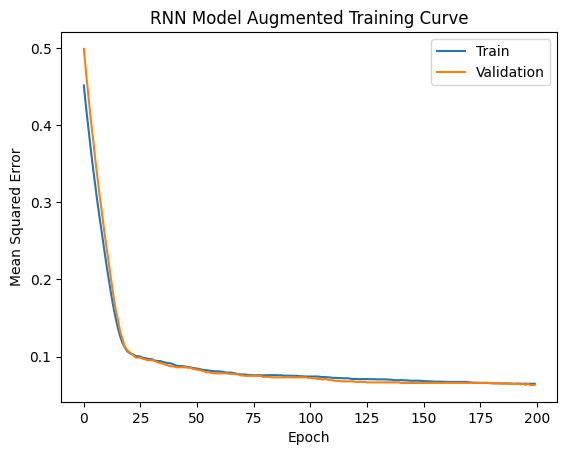

Test Data Accuracy:  0.057585139318885446
Test Data Increase/Decrease Accuracy:  0.4804953560371517


In [20]:
modelRNNAug = StocksRNN(4, 150)
train_rnn_network(modelRNNAug, 
                  training_files, 
                  validation_files, 
                  num_epochs=200, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=15, 
                  name="RNN Model Augmented", 
                  augment=True)
print("Test Data Accuracy: ", get_mean_squared_error(modelRNNAug, test_files, 15))
print("Test Data Increase/Decrease Accuracy: ", get_mean_squared_error(modelRNNAug, test_files, 15, incrDecr=True))

Epoch 10; Loss 4.377339; Train Acc 0.294771; Val Acc 0.327451
Epoch 20; Loss 1.704240; Train Acc 0.221133; Val Acc 0.245752
Epoch 30; Loss 0.914523; Train Acc 0.144009; Val Acc 0.152941
Epoch 40; Loss 0.571096; Train Acc 0.120697; Val Acc 0.121569
Epoch 50; Loss 1.502025; Train Acc 0.116993; Val Acc 0.115686
Epoch 60; Loss 1.052114; Train Acc 0.112418; Val Acc 0.111111
Epoch 70; Loss 0.699990; Train Acc 0.108715; Val Acc 0.107190
Epoch 80; Loss 0.611794; Train Acc 0.103268; Val Acc 0.101307
Epoch 90; Loss 1.124726; Train Acc 0.098911; Val Acc 0.096732
Epoch 100; Loss 0.404548; Train Acc 0.095425; Val Acc 0.090196
Epoch 110; Loss 0.532785; Train Acc 0.090414; Val Acc 0.086275
Epoch 120; Loss 0.385988; Train Acc 0.086928; Val Acc 0.081699
Epoch 130; Loss 0.324976; Train Acc 0.086275; Val Acc 0.081046
Epoch 140; Loss 0.193319; Train Acc 0.086492; Val Acc 0.081046
Epoch 150; Loss 0.475550; Train Acc 0.086275; Val Acc 0.080392
Epoch 160; Loss 0.233507; Train Acc 0.084967; Val Acc 0.080392
E

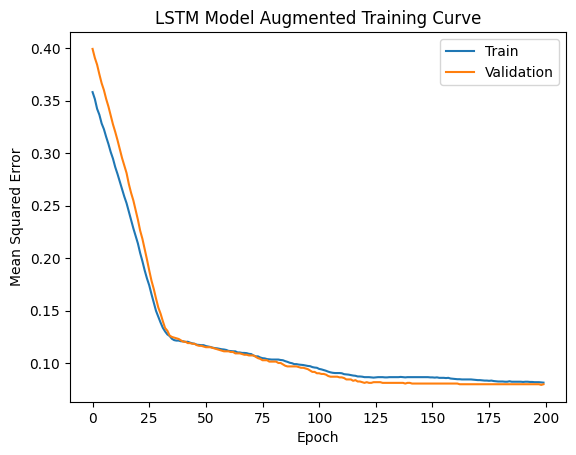

Test Data Accuracy:  0.07554179566563468
Test Data Increase/Decrease Accuracy:  0.4761609907120743


In [21]:
modelLSTMAug = StocksLSTM(4, 150)
train_rnn_network(modelLSTMAug, 
                  training_files, 
                  validation_files, 
                  num_epochs=200, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=15, 
                  name="LSTM Model Augmented", 
                  augment=True)
print("Test Data Accuracy: ", get_mean_squared_error(modelLSTMAug, test_files, 15))
print("Test Data Increase/Decrease Accuracy: ", get_mean_squared_error(modelLSTMAug, test_files, 15, incrDecr=True))

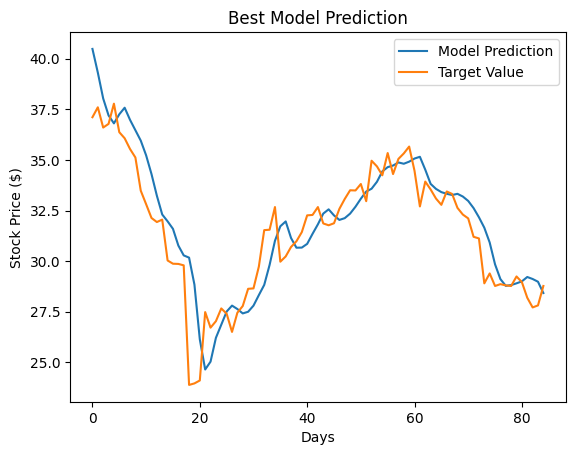

Best Model Prediction Error:  0.03529411764705882


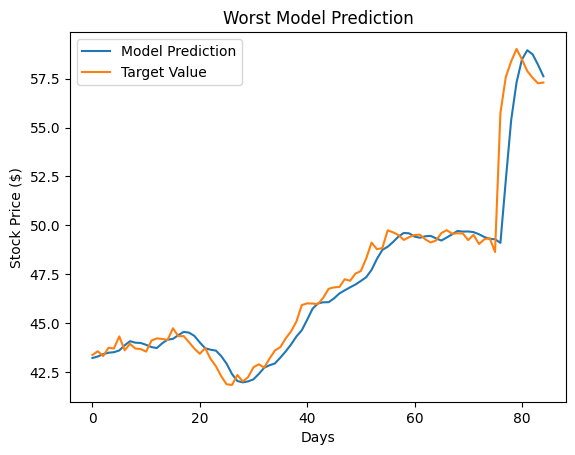

Worst Model Prediction Error:  0.17647058823529413


In [18]:
def goodBadExample(model, K, test_files=test_files):
    """
    Given a model, K, and test_files dataset, this function will output the 
    company with the worst mean squared error and the company with the best 
    mean squared error. Display a graph for which it least correctly predicted 
    the values and a graph for which it most correctly predicted the values.
    """
    bad_error, bad_file = float("-inf"), ""
    good_error, good_file = float("inf"), ""

    for f in test_files:
        error = get_mean_squared_error(model, [f], K)
        if error > bad_error:
            bad_error = error
            bad_file = f
        
        if error < good_error:
            good_error = error
            good_file = f

    X, T = transform_data(good_file, K)
    Y = model(X)

    plt.title("Best Model Prediction")
    plt.ylabel("Stock Price ($)")
    plt.xlabel("Days")
    plt.plot(np.arange(len(Y)), Y.detach().numpy(), label="Model Prediction")
    plt.plot(np.arange(len(T)), T, label="Target Value")
    plt.legend()
    plt.savefig("BestModelPrediction.png")
    plt.show()

    print("Best Model Prediction Error: ", 
          get_mean_squared_error(model, [good_file], K))

    X, T = transform_data(bad_file, K)
    Y = model(X)

    plt.title("Worst Model Prediction")
    plt.ylabel("Stock Price ($)")
    plt.xlabel("Days")
    plt.plot(np.arange(len(Y)), Y.detach().numpy(), label="Model Prediction")
    plt.plot(np.arange(len(T)), T, label="Target Value")
    plt.legend()
    plt.savefig("WorstModelPrediction.png")
    plt.show()

    print("Worst Model Prediction Error: ", 
          get_mean_squared_error(model, [bad_file], K))

goodBadExample(modelRNN, 15, test_files=test_files)

In [ ]:
def testModels(modelType):
    """
    Tests a RNN or LSTM model with the epochs, 50, 100, 200 and batch sizes of 
    500, 1000 and previous days of 5, 10, 15 and displays them in table.
    """
    print(modelType, "Model")
    print("Epochs\tBatch Size\tNum Days\tTraining Error\tValidation Error\tTest Error\tClassification Error")
    for epochs in [50, 100, 200]:
        for batch_size in [500, 1000]:
            for K in [5, 10, 15]:
                print(str(epochs) + "\t" + str(batch_size) + "\t\t" + str(K) + "\t\t", end="")
                if modelType == "RNN":
                    model = StocksRNN(4, 150)
                else:
                    model = StocksLSTM(4, 150)
                train_rnn_network(model, 
                                  training_files, 
                                  validation_files, 
                                  num_epochs=epochs, 
                                  batch_size=batch_size, 
                                  learning_rate=1e-5,
                                  K=K, 
                                  name=modelType, 
                                  show_data=False)
                train_acc = get_mean_squared_error(model, training_files, K)
                valid_acc = get_mean_squared_error(model, validation_files, K)
                test_acc = get_mean_squared_error(model, test_files, K)
                testc_acc = get_mean_squared_error(model, test_files, K, incrDecr=True)
                print(f'{train_acc:.6f}' + "\t", end="")
                print(f'{valid_acc:.6f}' + "\t\t", end="")
                print(f'{test_acc:.6f}' + "\t", end="")
                print(f'{testc_acc:.6f}' + "\t")

In [ ]:
testModels("LSTM")

LSTM Model
Epochs	Batch Size	Num Days	Training Error	Validation Error	Test Error	Classification Error
50	500		5		0.312865	0.316374		0.283657	0.470360	
50	500		10		0.242181	0.254938		0.222222	0.482456	
50	500		15		0.152723	0.164052		0.147988	0.490402	
50	1000		5		0.402729	0.417544		0.374515	0.477008	
50	1000		10		0.333951	0.361728		0.316374	0.482456	
50	1000		15		0.311329	0.342484		0.313313	0.489164	
100	500		5		0.252242	0.239181		0.221053	0.475346	
100	500		10		0.150000	0.139506		0.129240	0.486550	
100	500		15		0.114161	0.111111		0.104644	0.500310	
100	1000		5		0.345809	0.354971		0.316343	0.458726	
100	1000		10		0.260288	0.275926		0.243860	0.485380	
100	1000		15		0.195643	0.216340		0.195046	0.476161	
200	500		5		0.244444	0.227485		0.213296	0.485319	
200	500		10		0.136008	0.120370		0.114035	0.480702	
200	500		15		0.097821	0.094118		0.087926	0.490402	
200	1000		5		0.247953	0.232164		0.216066	0.489751	
200	1000		10		0.154321	0.141975		0.132164	0.485965	
200	1000		15		0.114597	0.109804		0.

In [ ]:
testModels("RNN")

RNN Model
Epochs	Batch Size	Num Days	Training Error	Validation Error	Test Error	Classification Error
50	500		5		0.239376	0.225731		0.208310	0.489197	
50	500		10		0.142181	0.130247		0.119298	0.486550	
50	500		15		0.130501	0.126797		0.119505	0.501548	
50	1000		5		0.264717	0.258480		0.232687	0.472022	
50	1000		10		0.255144	0.269753		0.238596	0.483626	
50	1000		15		0.102614	0.103922		0.095356	0.488545	
100	500		5		0.223197	0.209357		0.193352	0.478116	
100	500		10		0.140535	0.130247		0.119883	0.481871	
100	500		15		0.089760	0.085621		0.081734	0.484830	
100	1000		5		0.230214	0.212865		0.199446	0.483102	
100	1000		10		0.155350	0.144444		0.133333	0.484211	
100	1000		15		0.099564	0.094118		0.090402	0.492879	
200	500		5		0.210721	0.195322		0.182271	0.469806	
200	500		10		0.113169	0.103704		0.092398	0.485380	
200	500		15		0.077342	0.076471		0.070588	0.481734	
200	1000		5		0.232164	0.215789		0.201108	0.479778	
200	1000		10		0.130658	0.119753		0.110526	0.485380	
200	1000		15		0.087364	0.084967		0.0